In [82]:
import pandas as pd
import numpy as np
import re
import string

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score, jaccard_score
from scipy.cluster.hierarchy import dendrogram, linkage
from wordcloud import WordCloud, STOPWORDS

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv('netflix_titles.csv')
df.head()

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

## Data cleaning

### Looking for Duplicates 

In [3]:
df.duplicated().sum()

0

- There are no any duplicates.

### Handling Null Values

- From understanding data part we found there are multiple of columns with null values. They are:
    - director null rate: 29.91%
    - cast null rate: 9.37%
    - country null rate: 9.44%
    - date_added null rate: 0.11%
    - rating null rate: 0.05%

In [4]:
# Handling missing values
df[['director', 'cast', 'country']] = df[['director', 'cast', 'country']].fillna('Unknown')

# Handling rating null values
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])

# Hadling columns with time bu droping
df.dropna(axis=0, inplace=True)

In [5]:
df.shape

(8794, 12)

In [6]:
df.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

<br>

## 
Data Pre-Processing

- We are going to cluster shows on the basis of following learing parameters:
    - Director
    - Cast
    - Country
    - Genre (listed_in)
    - Description

In [7]:
df1 = df.copy()

In [8]:
df1['text_column'] = df1[['director', 'cast', 'country', 'listed_in', 'description']].fillna('').agg(' '.join, axis=1)
df1.head()

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water          Unknown   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans          Unknown   
4      s5  TV Show           Kota Factory          Unknown   

                                                cast        country  \
0                                            Unknown  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...        Unknown   
3                                            Unknown        Unknown   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  \
0  As her father nears the end of his life, filmm...   
1  After crossing paths at a party, a Cape Town t...   
2  To protect his family from a powerful drug lor...   
3  Feuds, flirtations and toilet talk go down amo...   
4  In a city of coaching centers known to train I...   

                                         text_column  
0  Kirsten Johnson Unknown United States Document...  
1  Unknown Ama Qamata, Khosi Ngema, Gail Mabalane...  
2  Julien Leclercq Sami Bouajila, Tracy Gotoas, S...  
3  Unknown Unknown Unknown Docuseries, Reality TV...  
4  Unknown Mayur More, Jitendra Kumar, Ranjan Raj...

## Text Preprocessing

Steps we do in text preprocessing:
1. Lowercase
2. Remove html, emoji 
3. Remove non-ASCII characters
4. Remove punctuation and characters
5. Remove stopwords
6. Lemmatization

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Load stopwords once to avoid repeatedly loading them in the loop
stop_words_set = set(stopwords.words('english'))

# Define the text preprocessing function
def text_preprocessing(text):
    # 1. Lowercase text
    text = text.lower()

    #2. remove html, emoji
    text = re.sub(r"https?\S+", "", text)

    # 3. Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 5. Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words_set])

    # 6. Lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text


In [11]:
df1['text_column'] = df1['text_column'].apply(text_preprocessing)

#### Tokenization

In [12]:
tokenizer = TweetTokenizer()
df1['text_column'] = df1['text_column'].apply(lambda x: tokenizer.tokenize(x))

# Joining the tokens back into a single string for TF-IDF.
df1['text_column'] = df1['text_column'].apply(lambda x: ' '.join(x))

#### Text Vectorization:

In [13]:
vectorizer = TfidfVectorizer()
corpus = df1['text_column']
output = vectorizer.fit_transform(corpus)

In [14]:
output.shape

(8794, 50417)

In [15]:
X = output.toarray()

<br>

## Dimensionality Reduction
- Principal Component Analysis

In [16]:
pca = PCA(n_components=3300, random_state=42)
X = pca.fit_transform(X)

In [27]:
X.shape

(8794, 3300)

### Cluster Implementation:
#### Partition Based Clustering

**Method to find out number of clusters for our dataset. We will visualize elbow curve and silhouette score to decide number of clusters for K-means clustering algorithm**

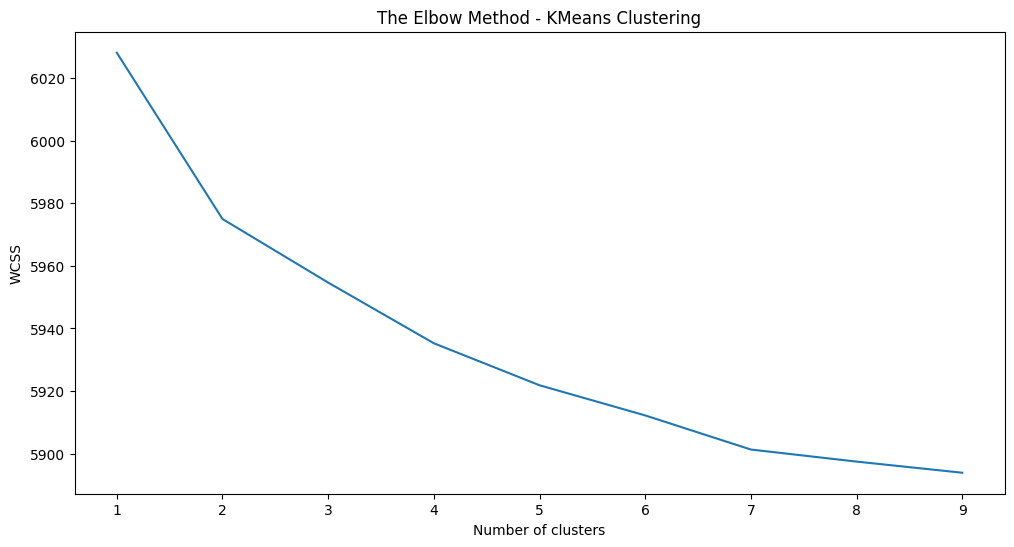

In [18]:
# Elbow Method
wcss = []
for i in range(1, 10):
    kmeans = KMeans(
        n_clusters=i, 
        init='k-means++',
        random_state=42
    )
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12, 6))
plt.plot(range(1,10), wcss)
plt.title('The Elbow Method - KMeans Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Disadvantage of elbow curve is that the sum of square could be range between varieties so to compact this number between 0-1 we use silhouette.

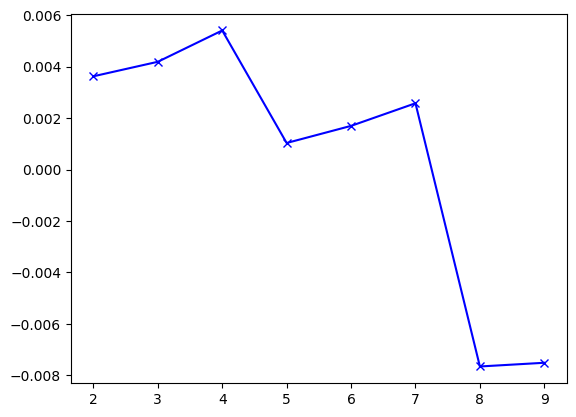

In [25]:
# Silhouwttw Method
silhouette = []
for i in range(2,10):
    kmeans = KMeans(
        n_clusters=i,
        random_state = 42
    )
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    silhouette.append(silhouette_score(X,cluster_labels))

plt.plot(range(2,10), silhouette, 'bx-')
plt.show()

**Optimal number of Clusters:4**
- Based on the curve, the optimal number of clusters can be determined by identifying the highest silhouette score. Therefore, the silhouette score is highest at 4 clusters.

In [23]:
# KMeans
k = 4
centroid_init = "k-means++"

kmeans_model = KMeans(n_clusters=k, init=centroid_init, random_state=42)
kmeans_model.fit(X)

KMeans(n_clusters=4, random_state=42)

#### Model Evaluation

In [26]:
# distortion, silhouette score
kmeans_distortion = kmeans_model.inertia_
kmeans_silhouette_score = silhouette_score(X, kmeans_model.labels_)

print((kmeans_distortion, kmeans_silhouette_score))

(5935.258412738056, 0.005412804084645023)


Interpretation
- Lower distortion indicates more compact clusters, which typically signifies better clustering. Here in out model it is high.
- A higher silhouette score indicates that the data points are well-clustered, with points in the same cluster being closer to each other and points in different clusters being far apart. Score close to 1 indicates dense and well-separated clusters, while score around 0 indicate ovelapping clusters. Negative scores suggest that data points might be assigned to the wrong clusters. Here our model's evaluation is almost 0.

<br>

### Hierarchical Clustering
#### Balanced Iterative Reducing and Clustering using Hierarchies (BIRCH)

In [28]:
model =Birch()
model.fit(X)

labels = model.labels_

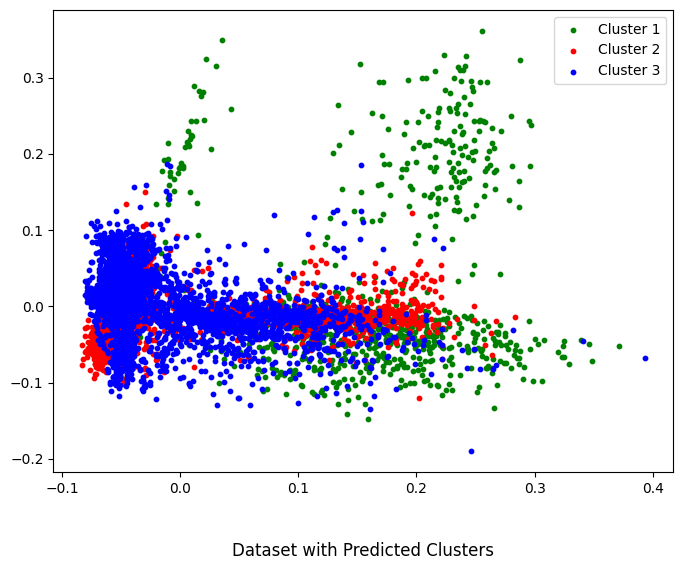

In [32]:
# Define colors for clusters
colors = ['green', 'red', 'blue', 'magenta', 'cyan', 'yellow', 'black', 'purple', 'orange', 'brown']

# Ensure you have enough colors
if num_clusters > len(colors):
    colors = plt.cm.rainbow(np.linspace(0, 1, num_clusters))

# Plot the dataset with predicted labels
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

for i in range(num_clusters):
    X_i = X[labels == i]
    ax.scatter(X_i[:, 0], X_i[:, 3], s=10, c=colors[i], label=f'Cluster {i+1}')

ax.set_title('Dataset with Predicted Clusters', y=-0.2)
ax.legend()

plt.show()

In [30]:
# Compute Silhouette Score
silhouette_avg = silhouette_score(X, labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: -0.0025069009909789958


**Interpretation**:
Silhouette score is negative which indicates that points might be assigned to the wrong cluster.

###  Agglomerative (hierarchical) clustering

#### Visualizing Dendrogram which displays the hierarchical relationship between clusters and helps decide the number of clusters by cutting at a particular height.

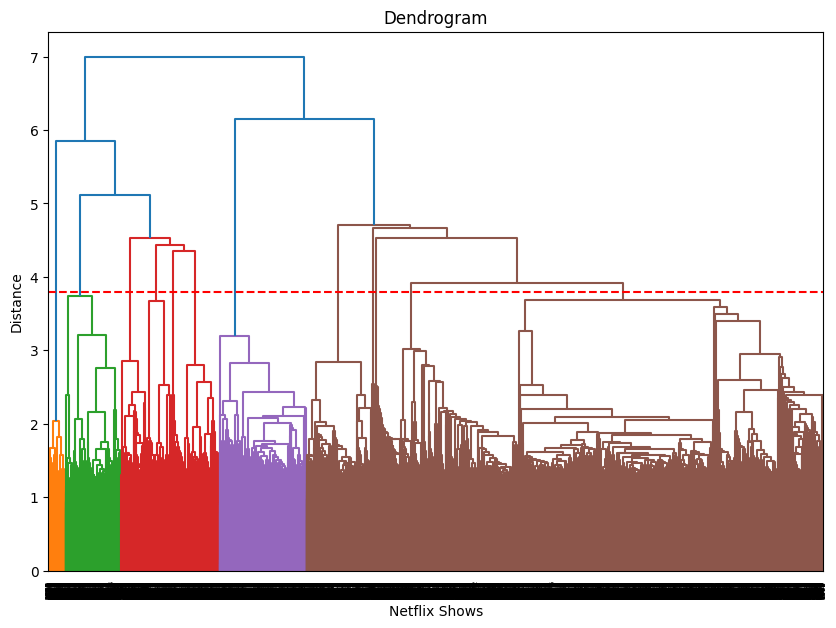

In [34]:
Z = linkage(X, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram(Z)
plt.xlabel('Netflix Shows')
plt.ylabel('Distance')
plt.axhline(y= 3.8, color='r', linestyle='--')
plt.show()

**At a distance of 3.8 units, 13 clusters can be built using the agglomerative hierarchical clustering algorithm.**

In [36]:
# Fit the model
model = AgglomerativeClustering(n_clusters=13, linkage='ward')
labels = model.fit_predict(X)

In [39]:
# Assigning cluster labels to the DataFrame
df1['hierarchical_cluster'] = labels

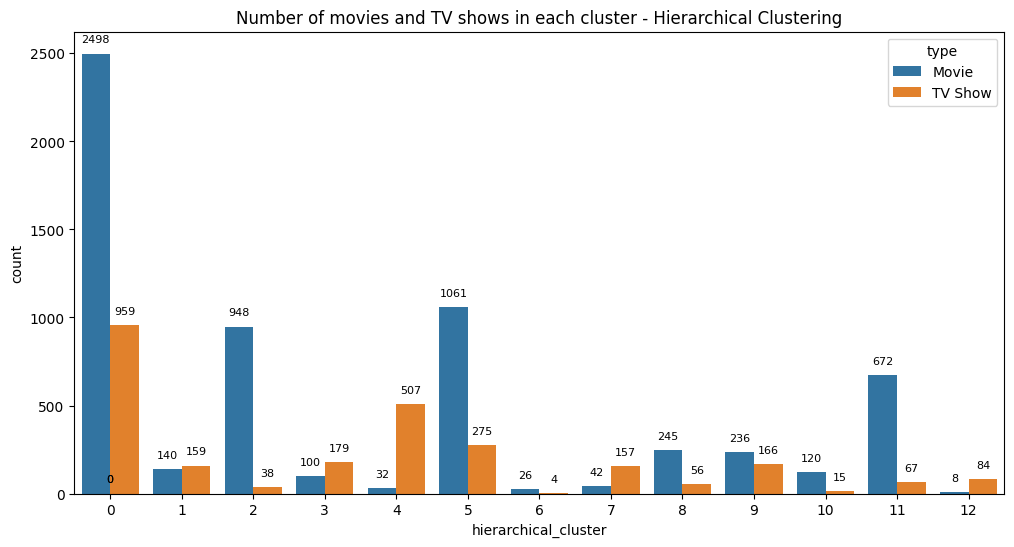

In [43]:
plt.figure(figsize=(12, 6))  # Adjusted the figure size
q = sns.countplot(x='hierarchical_cluster', data=df1, hue='type')
plt.title('Number of movies and TV shows in each cluster - Hierarchical Clustering')

for i in q.patches:
    q.annotate(format(i.get_height(), '.0f'), 
               (i.get_x() + i.get_width() / 2., i.get_height()), 
               ha='center', va='center', xytext=(0, 10), 
               textcoords='offset points', fontsize=8)  # Adjusted the fontsize for annotations

plt.show()

<br>

#### WordCloud for different Clusters.

In [49]:
def hierarchical_wordcloud_alt(df, cluster_num):
    stopwords = set(STOPWORDS)

    # Filter the DataFrame for the specified cluster
    cluster_df = df[df['hierarchical_cluster'] == cluster_num]

    comment_words = ''
    # Iterate through the filtered DataFrame
    for val in cluster_df['description'].values:
        # typecast each val to string
        val = str(val)
        # split the value
        tokens = val.split()
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens) + " "

    # Generate word cloud for the specified cluster
    wordcloud = WordCloud(width=700, height=700,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(comment_words)

    # Plot the WordCloud image
    plt.figure(figsize=(10, 5), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(f"Word Cloud for Cluster {cluster_num}")
    plt.show()

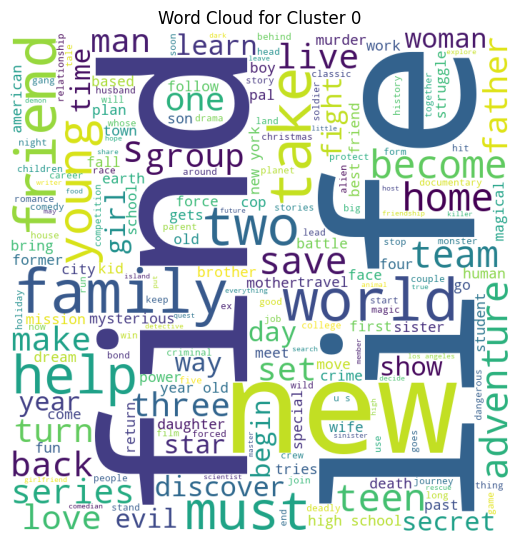

In [51]:
# For cluster 0
hierarchical_wordcloud_alt(df1, 0)

- **keywords observed in cluster 0: life, find, family, new, two, world, series, love, adventure, team, friend**

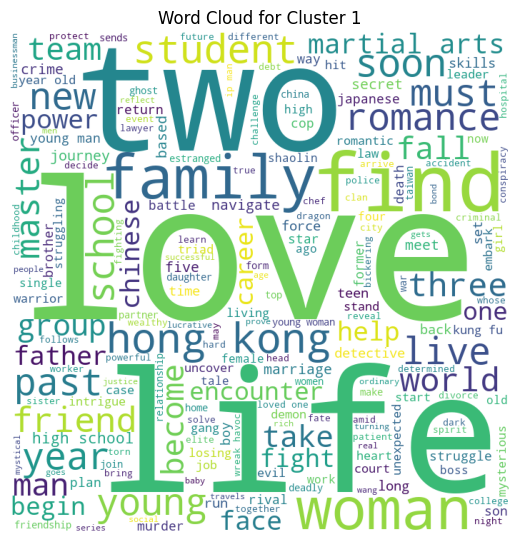

In [53]:
# Wordcloud for 1
hierarchical_wordcloud_alt(df1, 1)

- **keywords observed in cluster 1: two, family, find, love, hongkong, life, woman, romance, past, world, martial arts**

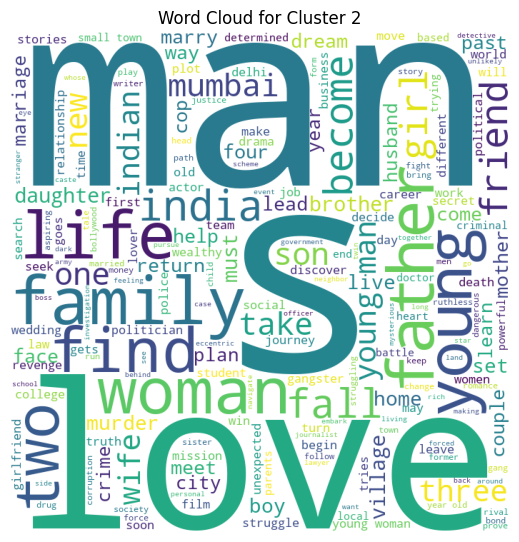

In [54]:
# Wordcloud for 2
hierarchical_wordcloud_alt(df1, 2)

- **keywords observed in cluster 2: man, life, india, family, love, wife, young, friend, take, father**

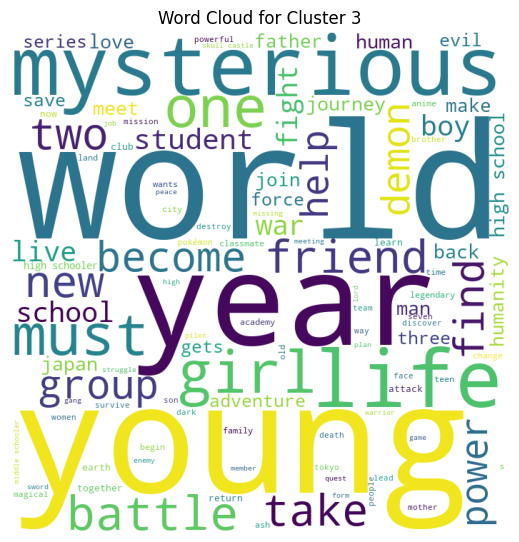

In [55]:
# Wordcloud for 3
hierarchical_wordcloud_alt(df1, 3)

- **keywords observed in cluster 3: mysterious, world, year, girl, life, young, battle, take, power**

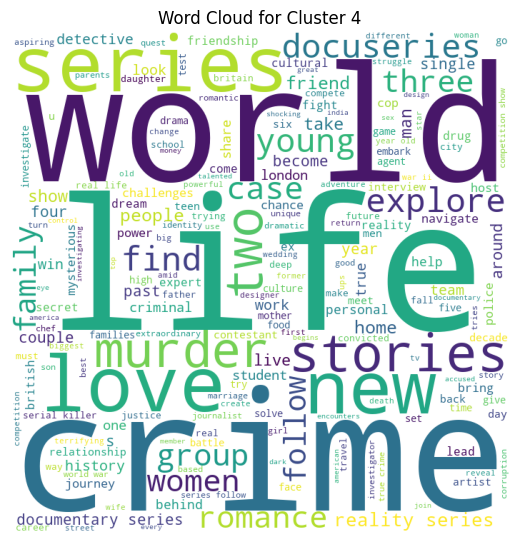

In [56]:
# Wordcloud for 4
hierarchical_wordcloud_alt(df1, 4)

- **keywords observed in cluster 4: series, docuseries, world, life, love, crime, stories, crime, murder**

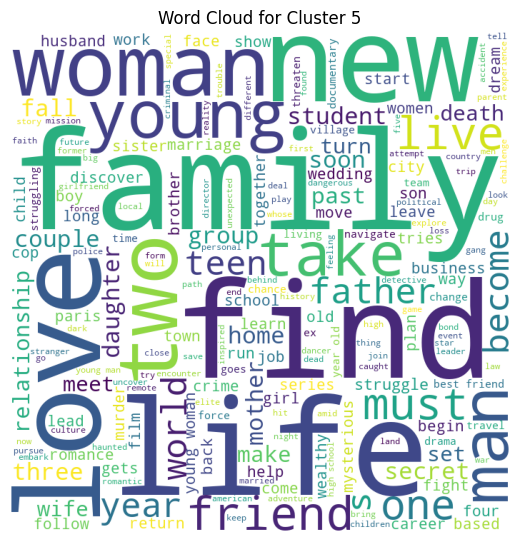

In [57]:
# Wordcloud for 5
hierarchical_wordcloud_alt(df1, 5)

- **keywords observed in cluster 5: women, new, young, family, find, life, love, friend, must**

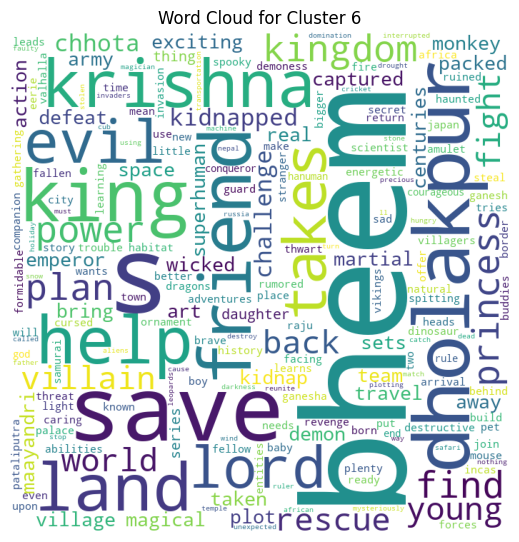

In [58]:
# Wordcloud for 6
hierarchical_wordcloud_alt(df1, 6)

- **keywords observed in cluster 6: krishna, evil, king, bheem, save, land, world, dholakpur, land, friend, rescue, princess**

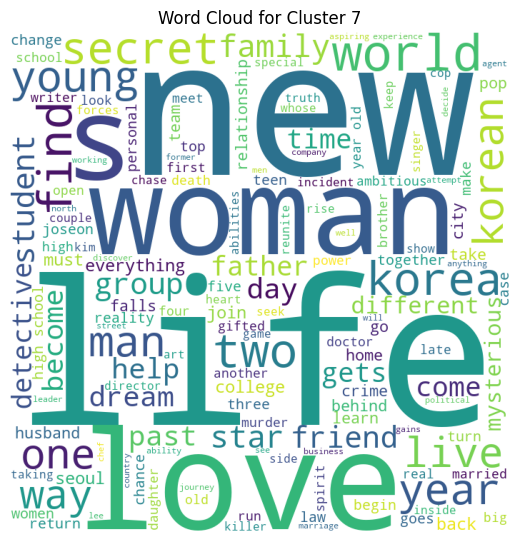

In [59]:
# Wordcloud for 7
hierarchical_wordcloud_alt(df1, 7)

- **keywords observed in cluster 7: new, woman, life, love, korea, year, secret, detective, student, korean, young**

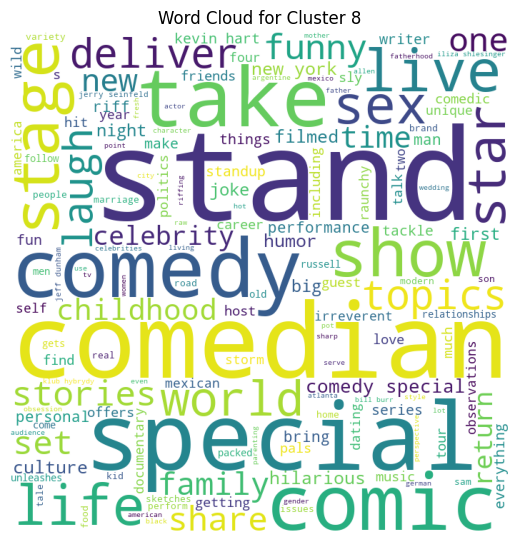

In [60]:
# Wordcloud for 8
hierarchical_wordcloud_alt(df1, 8)

- **keywords observed in cluster 8: deliver, take, sex, comedy, comedian, special, show, topics, stage, laugh, life, comic, comedy special, celebrity**

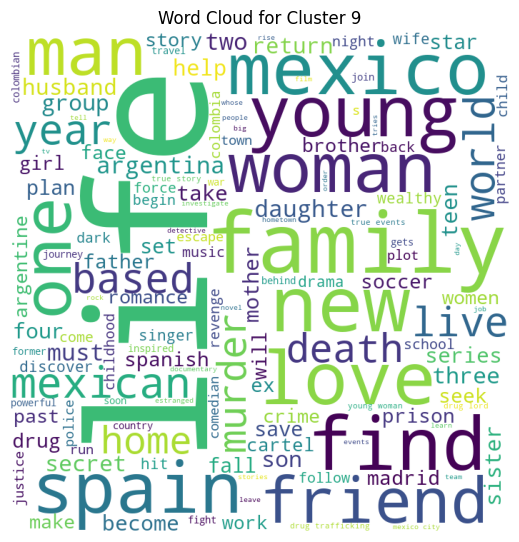

In [61]:
# Wordcloud for 9
hierarchical_wordcloud_alt(df1, 9)

- **keywords observed in cluster 9: man, mexico, young, love, death, family, spain, mexican, friend, one, new, live**

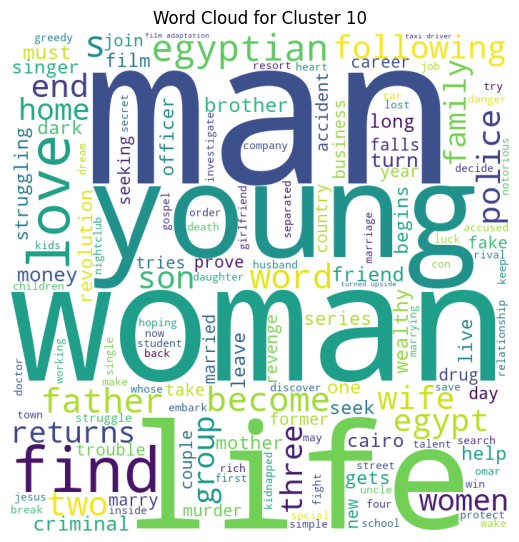

In [63]:
# Wordcloud for 10
hierarchical_wordcloud_alt(df1, 10)

- **keywords observed in cluster 10: egyptian, man, young, woman, life, find, returns, love, home, end, father, become, egypt, three, police**

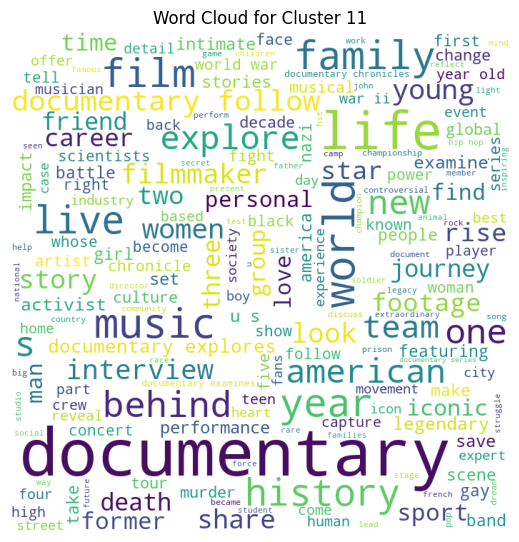

In [64]:
# Wordcloud for 11
hierarchical_wordcloud_alt(df1, 11)

- **keywords observed in cluster 11: film, family, young, explore, music, documentary, music, american, year, history, share, interview, former**

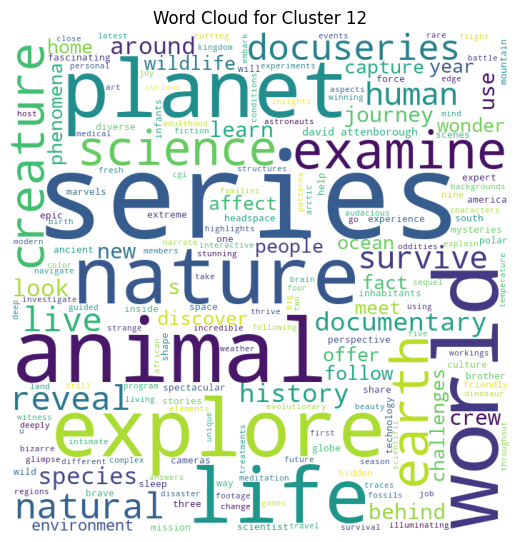

In [65]:
# Wordcloud for 12
hierarchical_wordcloud_alt(df1, 12)

- **keywords observed in cluster 12: around, docuseries, planet, series, science, nature, survive, world, animal, explore, life, natural, species, examine, human**

<br>

## Content Based Recommendation System.

### Recommendation System based on the similarity scores.
- Content based recommendation system based on the similarity of the types.

#### Using CountVectorizer() for the text vectorization instead of TfidfVectorizer.
Taking all preprocessing text from before for vectorization

In [84]:
vectorize = CountVectorizer()
corpus = df1['text_column']
count_matix = vectorize.fit_transform(corpus)

#### Computing cosine similarity between the features vectors of the shows.

In [86]:
cosine_sim = cosine_similarity(count_matix, count_matix)

In [119]:
# Define the recommendation function with error handling
def recommendation(title, top_n=10):
    try:
        cosine_sim
        idx = df1[df1['title']==title].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]
        show_indices = [i[0] for i in sim_scores]
        recommendations = df[['title']].iloc[show_indices]
        return recommendations['title'].tolist()

    except IndexError:
        print(f"Title '{title}' is not available on Netflix.")
        return 
        
    except Exception as e:
        print(f"An error occurred: {e}")
        return

In [120]:
recommendation('Stranger Things')

['Beyond Stranger Things',
 'The Umbrella Academy',
 'The Mole',
 'Nightflyers',
 'Prank Encounters',
 'Anjaan: Special Crimes Unit',
 'Warrior Nun',
 'Scream',
 'The Sinner',
 'Haunted']

In [121]:
recommendation('Peaky Blinders')

['Kiss Me First',
 'Glow Up',
 'I AM A KILLER',
 'London Spy',
 'The Irregulars',
 'Happy Valley',
 'The Frankenstein Chronicles',
 'Killer Ratings',
 'Paranoid',
 'Inside the World’s Toughest Prisons']

In [122]:
recommendation('Lucifer')

['Rica, Famosa, Latina',
 'The Good Cop',
 'Get Shorty',
 'L.A.’s Finest',
 'Dramaworld',
 'The Expanding Universe of Ashley Garcia',
 'Better Call Saul',
 'Person of Interest',
 'Jack Taylor',
 'Forensic Files']

In [123]:
recommendation('The Sinner')

['Frequency',
 'L.A.’s Finest',
 'The Umbrella Academy',
 'Disappearance',
 'The Keepers',
 'The Good Cop',
 'Get Shorty',
 'MINDHUNTER',
 'The Mole',
 'Evil Genius']

In [124]:
recommendation('Squid Game')

['Mad for Each Other',
 'Memories of the Alhambra',
 'Chief of Staff',
 "Hyori's Bed & Breakfast",
 'Racket Boys',
 'Romance is a bonus book',
 'Prison Playbook',
 'Touch Your Heart',
 'Happy And',
 'The Lady in Dignity']

In [125]:
recommendation('Spider-man')

Title 'Spider-man' is not available on Netflix.
